--- Running 1D Cylindrical Transient Model for Westinghouse PWR (Appendix H) ---
Initializing grids and matrices for cylindrical geometry...

--- Starting EXPLICIT Simulation ---
Time step (dt): 1.00e-05 seconds
Explicit simulation finished in 964.89 seconds.

--- Starting IMPLICIT Simulation ---
Time step (dt): 0.25 seconds
Implicit simulation finished in 0.05 seconds.

--- Generating Plots ---

--- Simulation Summary ---
Explicit Method CPU Time: 964.89 s
  - Final Centerline Temp: 841.80 °C
Implicit Method CPU Time: 0.05 s
  - Final Centerline Temp: 841.79 °C

--- Validation Check ---
This simulation uses the AVERAGE linear power (178 W/cm).
The table's Maximum Fuel Temperature (1788°C) corresponds to the MAXIMUM linear power (426 W/cm).
Our calculated average centerline temperature of ~842°C is expected to be significantly lower than the maximum value.
The thermal peaking factor is 2.39.


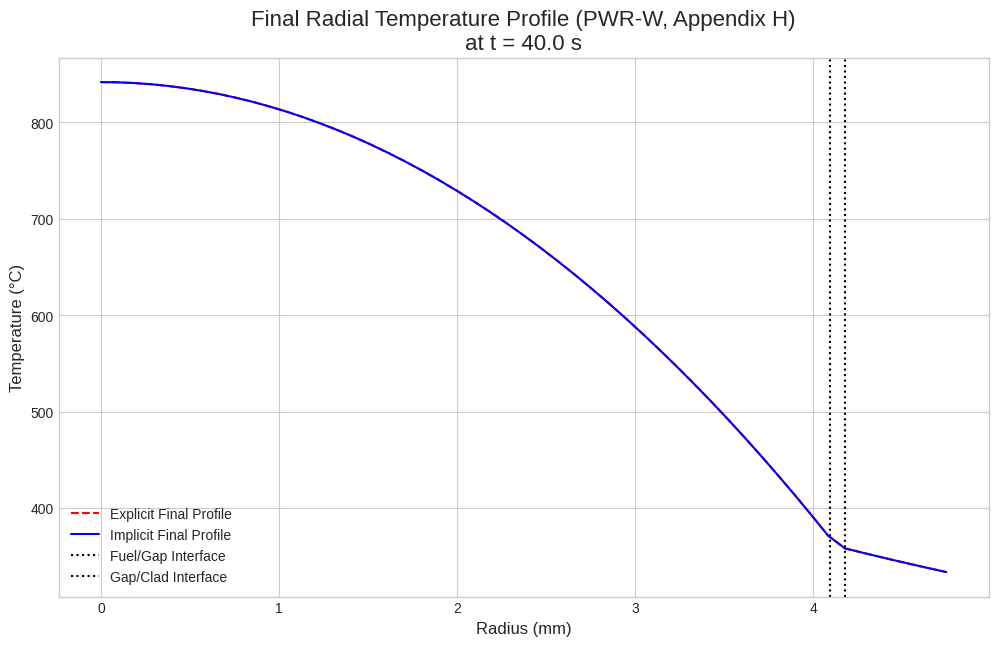

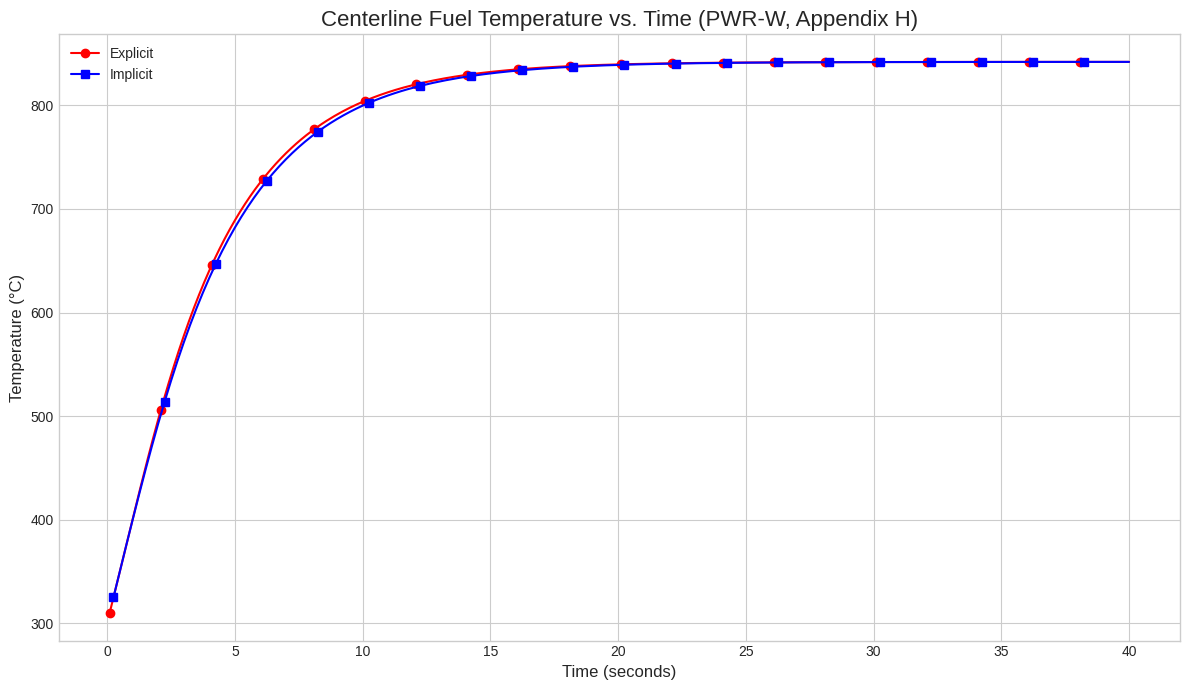

In [3]:
# This block addresses questions B1 and B2: solving time-dependent heat transfer problem using implicit and explicit methods
# h is assumed 35000, should be adapted for

import numpy as np
import matplotlib.pyplot as plt
import time

# =============================================================================
# 1. Physical, Numerical, and Time Parameters
#    (Values updated based on Appendix H for a Westinghouse PWR)
# =============================================================================
print('--- Running 1D Cylindrical Transient Model for Westinghouse PWR (Appendix H) ---')

# --- Method Selection ---
run_explicit = True
run_implicit = True

# --- Material IDs ---
FUEL_ID = 1
GAP_ID = 2
CLAD_ID = 3

# --- Geometry (From Appendix H, PWR-W) ---
r_fuel = 0.004095      # m, From 0.819 cm pellet diameter
gap_thickness = 0.000082   # m, From 0.0082 cm pellet-clad gap
clad_thickness = 0.000572  # m, From 0.0572 cm clad thickness
r_gap = r_fuel + gap_thickness
r_clad = r_gap + clad_thickness
L = 1.0                    # Assume unit length of 1 meter for 1D analysis

# --- Material Properties (Standard values for specified materials) ---
# 1. Uranium Dioxide (UO2) Fuel
k_fuel = 3.0        # W/m-K, Standard value for UO2 fuel
rho_fuel = 10500    # kg/m^3, Density
cp_fuel = 320       # J/kg-K, Specific Heat
# Calculated from Average Linear Power Density (178 W/cm) from Appendix H
q_gen_fuel = 3.385e8 # W/m^3, Volumetric heat generation

# 2. Gap (Helium)
k_gap = 0.15        # W/m-K, Thermal conductivity
rho_gap = 0.166     # kg/m^3, Density of He at high temp/pressure
cp_gap = 5193       # J/kg-K, Specific Heat of He
q_gen_gap = 0

# 3. Cladding (Zircaloy)
k_clad = 15.0       # W/m-K, Standard value for Zircaloy
rho_clad = 6550     # kg/m^3, Density
cp_clad = 330       # J/kg-K, Specific Heat
q_gen_clad = 0

# --- Boundary & Initial Conditions (From Appendix H, PWR-W) ---
h = 35000           # W/m^2-K, Standard convective coefficient for PWRs
# Average of Inlet (300 C) and Outlet (332 C) temperatures
T_inf = 316.0       # Celsius, Ambient fluid temperature
# Set to coolant inlet temperature
T_initial = 300.0   # Celsius, Initial temperature of the entire domain

# --- Numerical Grid ---
N = 51              # Total number of radial nodes

# --- Time Parameters ---
total_time = 40.0     # Total simulation time (seconds)
dt_explicit = 1e-5  # Timestep for explicit stability
dt_implicit = 0.25  # Timestep for implicit method

# =============================================================================
# 2. Initialization (CRITICAL FOR CYLINDRICAL GEOMETRY)
# =============================================================================
print('Initializing grids and matrices for cylindrical geometry...')

# --- Create Radial Grid ---
# r_nodes: Radial position of the center of each control volume
# r_faces: Radial position of the interfaces between control volumes
r_nodes = np.linspace(0, r_clad, N)
dr = r_nodes[1] - r_nodes[0]
# Faces are halfway between nodes. r_faces[i] is the face between node i and i+1
r_faces = r_nodes[:-1] + dr / 2.0
# Add the outer boundary face
r_faces = np.append(r_faces, r_clad)

# --- Calculate Geometric Properties of Control Volumes ---
# cell_volumes: Volume of each annular control volume
cell_volumes = np.zeros(N)
# Center node is a solid cylinder
cell_volumes[0] = np.pi * r_faces[0]**2 * L
# Other nodes are annular rings
for i in range(1, N):
    cell_volumes[i] = np.pi * (r_faces[i]**2 - r_faces[i-1]**2) * L

# face_areas: Area of the cylindrical face between control volumes
face_areas = 2 * np.pi * r_faces * L

# --- Assign Material IDs to each node ---
material_ID_array = np.zeros(N, dtype=int)
for i in range(N):
    r = r_nodes[i]
    if r <= r_fuel:
        material_ID_array[i] = FUEL_ID
    elif r <= r_gap:
        material_ID_array[i] = GAP_ID
    else:
        material_ID_array[i] = CLAD_ID

# --- Store material properties in lists for easy lookup ---
# Index 0 is a dummy value, so we can use material IDs (1, 2, 3) directly
k_vals = [0, k_fuel, k_gap, k_clad]
rho_vals = [0, rho_fuel, rho_gap, rho_clad]
cp_vals = [0, cp_fuel, cp_gap, cp_clad]
q_gen_vals = [0, q_gen_fuel, q_gen_gap, q_gen_clad]

# --- Initialize Temperature and History Arrays ---
T_explicit = np.full(N, T_initial)
T_implicit = np.full(N, T_initial)

time_hist_exp, temp_hist_exp = [], []
time_hist_imp, temp_hist_imp = [], []

# =============================================================================
# 3. EXPLICIT METHOD SIMULATION
# =============================================================================
if run_explicit:
    print(f'\n--- Starting EXPLICIT Simulation ---')
    print(f'Time step (dt): {dt_explicit:.2e} seconds')

    T_old = T_explicit.copy()
    num_steps = round(total_time / dt_explicit)

    start_time = time.time()
    for step in range(num_steps):
        T_new = T_old.copy()
        for i in range(N): # Loop over all nodes
            # Get properties for the current node (P)
            mat_id_p = material_ID_array[i]
            rho_p = rho_vals[mat_id_p]
            cp_p = cp_vals[mat_id_p]
            q_gen_p = q_gen_vals[mat_id_p]
            k_p = k_vals[mat_id_p]

            # --- Heat Balance Calculation ---
            Q_in = 0.0  # Heat conducted in from inner neighbor (West)
            Q_out = 0.0 # Heat conducted out to outer neighbor (East)

            # Inner neighbor (West)
            if i > 0:
                k_W = k_vals[material_ID_array[i-1]]
                k_eff = 2 * k_p * k_W / (k_p + k_W) # Harmonic mean for interface conductivity
                Q_in = k_eff * face_areas[i-1] * (T_old[i-1] - T_old[i]) / dr

            # Outer neighbor (East)
            if i < N - 1:
                k_E = k_vals[material_ID_array[i+1]]
                k_eff = 2 * k_p * k_E / (k_p + k_E)
                Q_out = k_eff * face_areas[i] * (T_old[i] - T_old[i+1]) / dr

            # Convection at the outer boundary (only for the last node)
            Q_conv = 0.0
            if i == N - 1:
                Q_conv = h * face_areas[N-1] * (T_inf - T_old[i])

            # Total heat balance for the node
            heat_balance = Q_in - Q_out + Q_conv + q_gen_p * cell_volumes[i]

            # Update temperature
            T_new[i] = T_old[i] + (dt_explicit / (rho_p * cp_p * cell_volumes[i])) * heat_balance

        T_old = T_new

        # Record history periodically
        if (step + 1) % 10000 == 0:
            current_time = (step + 1) * dt_explicit
            time_hist_exp.append(current_time)
            temp_hist_exp.append(T_old[0])

    explicit_time = time.time() - start_time
    T_explicit = T_old
    print(f'Explicit simulation finished in {explicit_time:.2f} seconds.')

# =============================================================================
# 4. IMPLICIT METHOD SIMULATION
# =============================================================================
if run_implicit:
    print(f'\n--- Starting IMPLICIT Simulation ---')
    print(f'Time step (dt): {dt_implicit:.2f} seconds')

    T_old_vector = T_implicit.copy()
    num_steps = round(total_time / dt_implicit)

    start_time = time.time()
    for step in range(num_steps):
        A_matrix = np.zeros((N, N))
        b_vector = np.zeros(N)

        for i in range(N): # Loop over nodes to build the matrix
            # Get material properties
            mat_id_p = material_ID_array[i]
            rho_p = rho_vals[mat_id_p]
            cp_p = cp_vals[mat_id_p]
            q_gen_p = q_gen_vals[mat_id_p]
            k_p = k_vals[mat_id_p]

            # --- Assemble A matrix and b vector ---
            # Equation form: a_P * T_i_new - a_W * T_{i-1}_new - a_E * T_{i+1}_new = b_i

            # Transient term coefficient
            transient_coeff = (rho_p * cp_p * cell_volumes[i]) / dt_implicit

            # Initialize RHS (b_vector) with known terms
            b_i = transient_coeff * T_old_vector[i] + q_gen_p * cell_volumes[i]

            # Initialize the main diagonal of LHS (A_matrix)
            a_P_diag = transient_coeff

            # West (inner) neighbor coefficient
            if i > 0:
                k_W = k_vals[material_ID_array[i-1]]
                k_eff = 2 * k_p * k_W / (k_p + k_W)
                a_W = k_eff * face_areas[i-1] / dr
                A_matrix[i, i-1] = -a_W
                a_P_diag += a_W

            # East (outer) neighbor coefficient
            if i < N - 1:
                k_E = k_vals[material_ID_array[i+1]]
                k_eff = 2 * k_p * k_E / (k_p + k_E)
                a_E = k_eff * face_areas[i] / dr
                A_matrix[i, i+1] = -a_E
                a_P_diag += a_E

            # Boundary term (Convection at outer surface)
            if i == N - 1:
                conv_coeff = h * face_areas[N-1]
                a_P_diag += conv_coeff
                b_i += conv_coeff * T_inf

            # Assign final diagonal and source terms
            A_matrix[i, i] = a_P_diag
            b_vector[i] = b_i

        # Solve the linear system A * T_new = b
        T_new_vector = np.linalg.solve(A_matrix, b_vector)
        T_old_vector = T_new_vector

        # Record history
        current_time = (step + 1) * dt_implicit
        time_hist_imp.append(current_time)
        temp_hist_imp.append(T_old_vector[0])

    implicit_time = time.time() - start_time
    T_implicit = T_old_vector
    print(f'Implicit simulation finished in {implicit_time:.2f} seconds.')

# =============================================================================
# 5. Visualization and Comparison
# =============================================================================
print('\n--- Generating Plots ---')
plt.style.use('seaborn-v0_8-whitegrid')

# --- Final Temperature Profile vs. Radius ---
fig1, ax1 = plt.subplots(figsize=(12, 7))
if run_explicit:
    ax1.plot(r_nodes * 1000, T_explicit, 'r--', label='Explicit Final Profile')
if run_implicit:
    ax1.plot(r_nodes * 1000, T_implicit, 'b-', label='Implicit Final Profile')
ax1.set_title(f'Final Radial Temperature Profile (PWR-W, Appendix H)\nat t = {total_time} s', fontsize=16)
ax1.set_xlabel('Radius (mm)', fontsize=12)
ax1.set_ylabel('Temperature (°C)', fontsize=12)
ax1.legend()
ax1.grid(True)

# Add vertical lines for material interfaces
ax1.axvline(x=r_fuel*1000, color='k', linestyle=':', linewidth=1.5, label='Fuel/Gap Interface')
ax1.axvline(x=r_gap*1000, color='k', linestyle=':', linewidth=1.5, label='Gap/Clad Interface')
ax1.legend()


# --- Centerline Temperature vs. Time ---
fig2, ax2 = plt.subplots(figsize=(12, 7))
if run_explicit:
    ax2.plot(time_hist_exp, temp_hist_exp, 'r-o', label='Explicit', markevery=len(time_hist_exp)//20)
if run_implicit:
    ax2.plot(time_hist_imp, temp_hist_imp, 'b-s', label='Implicit', markevery=len(time_hist_imp)//20)
ax2.set_title('Centerline Fuel Temperature vs. Time (PWR-W, Appendix H)', fontsize=16)
ax2.set_xlabel('Time (seconds)', fontsize=12)
ax2.set_ylabel('Temperature (°C)', fontsize=12)
ax2.legend()
ax2.grid(True)

# --- Simulation Summary ---
print('\n--- Simulation Summary ---')
if run_explicit:
    print(f'Explicit Method CPU Time: {explicit_time:.2f} s')
    final_temp_exp = temp_hist_exp[-1] if temp_hist_exp else float('nan')
    print(f'  - Final Centerline Temp: {final_temp_exp:.2f} °C')
if run_implicit:
    print(f'Implicit Method CPU Time: {implicit_time:.2f} s')
    final_temp_imp = temp_hist_imp[-1] if temp_hist_imp else float('nan')
    print(f'  - Final Centerline Temp: {final_temp_imp:.2f} °C')

# --- Validation against Appendix H ---
print('\n--- Validation Check ---')
max_fuel_temp_table = 1788 # °C, from Appendix H
avg_lin_power = 178 # W/cm
max_lin_power = 426 # W/cm
peaking_factor = max_lin_power / avg_lin_power
print(f'This simulation uses the AVERAGE linear power ({avg_lin_power} W/cm).')
print(f'The table\'s Maximum Fuel Temperature ({max_fuel_temp_table}°C) corresponds to the MAXIMUM linear power ({max_lin_power} W/cm).')
print(f'Our calculated average centerline temperature of ~{final_temp_imp:.0f}°C is expected to be significantly lower than the maximum value.')
print(f'The thermal peaking factor is {peaking_factor:.2f}.')


plt.tight_layout()
plt.show()

--- Running 1D Cylindrical Transient Model for Westinghouse PWR (Appendix H) ---
Initializing grids and matrices for cylindrical geometry...

--- PART B3, STAGE 1: Calculating Steady-State Profile ---
Running implicit simulation from cold start to find steady-state.
Time step (dt): 0.25 seconds
Stage 1 finished in 0.05 seconds.
Steady-state centerline temperature calculated: 841.79 °C

--- PART B3, STAGE 2: Verification Run ---
Using the calculated steady-state profile as the initial condition.
Starting verification run for 10.0 seconds...
Initial centerline temperature: 841.7931 °C
Final centerline temperature after 10.0s: 841.8063 °C
Verification run finished in 0.013 seconds.

--- Generating Plot for Part B3 ---


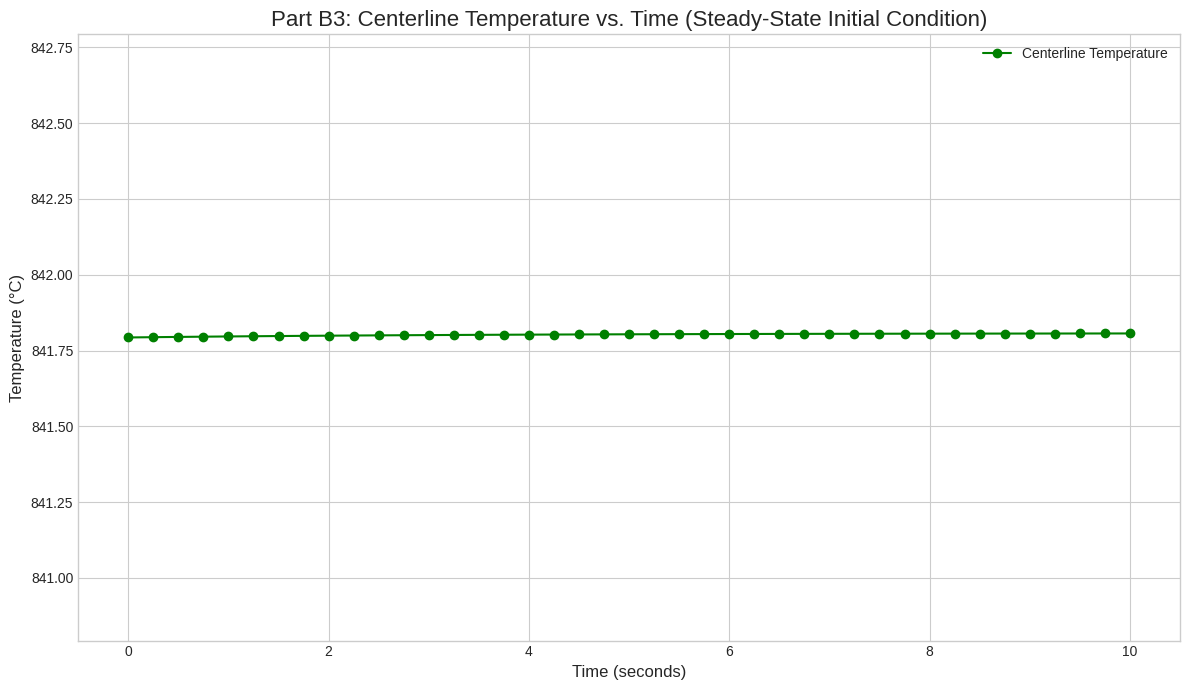

In [4]:
# This block address question B.3: establish steady state conditions before starting transient

import numpy as np
import matplotlib.pyplot as plt
import time

# =============================================================================
# 1. Physical, Numerical, and Time Parameters
#    (Values updated based on Appendix H for a Westinghouse PWR)
# =============================================================================
print('--- Running 1D Cylindrical Transient Model for Westinghouse PWR (Appendix H) ---')

# --- Method Selection ---
# For B3, we only need the efficient implicit method.
run_explicit = False
run_implicit = True

# --- Material IDs ---
FUEL_ID = 1
GAP_ID = 2
CLAD_ID = 3

# --- Geometry (From Appendix H, PWR-W) ---
r_fuel = 0.004095      # m, From 0.819 cm pellet diameter
gap_thickness = 0.000082   # m, From 0.0082 cm pellet-clad gap
clad_thickness = 0.000572  # m, From 0.0572 cm clad thickness
r_gap = r_fuel + gap_thickness
r_clad = r_gap + clad_thickness
L = 1.0                    # Assume unit length of 1 meter for 1D analysis

# --- Material Properties (Standard values for specified materials) ---
# 1. Uranium Dioxide (UO2) Fuel
k_fuel = 3.0        # W/m-K, Standard value for UO2 fuel
rho_fuel = 10500    # kg/m^3, Density
cp_fuel = 320       # J/kg-K, Specific Heat
q_gen_fuel = 3.385e8 # W/m^3, Volumetric heat generation

# 2. Gap (Helium)
k_gap = 0.15        # W/m-K, Thermal conductivity
rho_gap = 0.166     # kg/m^3, Density of He at high temp/pressure
cp_gap = 5193       # J/kg-K, Specific Heat of He
q_gen_gap = 0

# 3. Cladding (Zircaloy)
k_clad = 15.0       # W/m-K, Standard value for Zircaloy
rho_clad = 6550     # kg/m^3, Density
cp_clad = 330       # J/kg-K, Specific Heat
q_gen_clad = 0

# --- Boundary & Initial Conditions (From Appendix H, PWR-W) ---
h = 35000           # W/m^2-K, Standard convective coefficient for PWRs
T_inf = 316.0       # Celsius, Ambient fluid temperature
T_initial = 300.0   # Celsius, Initial temperature for the "cold start" run

# --- Numerical Grid ---
N = 51              # Total number of radial nodes

# --- Time Parameters ---
total_time = 40.0     # Total simulation time to reach steady-state
dt_implicit = 0.25  # Timestep for implicit method

# =============================================================================
# 2. Initialization (CRITICAL FOR CYLINDRICAL GEOMETRY)
# =============================================================================
print('Initializing grids and matrices for cylindrical geometry...')

# --- Create Radial Grid ---
r_nodes = np.linspace(0, r_clad, N)
dr = r_nodes[1] - r_nodes[0]
r_faces = r_nodes[:-1] + dr / 2.0
r_faces = np.append(r_faces, r_clad)

# --- Calculate Geometric Properties of Control Volumes ---
cell_volumes = np.zeros(N)
cell_volumes[0] = np.pi * r_faces[0]**2 * L
for i in range(1, N):
    cell_volumes[i] = np.pi * (r_faces[i]**2 - r_faces[i-1]**2) * L
face_areas = 2 * np.pi * r_faces * L

# --- Assign Material IDs to each node ---
material_ID_array = np.zeros(N, dtype=int)
for i in range(N):
    r = r_nodes[i]
    if r <= r_fuel:
        material_ID_array[i] = FUEL_ID
    elif r <= r_gap:
        material_ID_array[i] = GAP_ID
    else:
        material_ID_array[i] = CLAD_ID

# --- Store material properties in lists for easy lookup ---
k_vals = [0, k_fuel, k_gap, k_clad]
rho_vals = [0, rho_fuel, rho_gap, rho_clad]
cp_vals = [0, cp_fuel, cp_gap, cp_clad]
q_gen_vals = [0, q_gen_fuel, q_gen_gap, q_gen_clad]

# =============================================================================
# 3. PART B3, STAGE 1: Calculate the Steady-State Profile
# =============================================================================
T_steady_state = np.array([]) # Initialize empty array

if run_implicit:
    print(f'\n--- PART B3, STAGE 1: Calculating Steady-State Profile ---')
    print(f'Running implicit simulation from cold start to find steady-state.')
    print(f'Time step (dt): {dt_implicit:.2f} seconds')

    # Initialize from cold start
    T_old_vector = np.full(N, T_initial)
    num_steps = round(total_time / dt_implicit)

    start_time = time.time()
    for step in range(num_steps):
        A_matrix = np.zeros((N, N))
        b_vector = np.zeros(N)

        for i in range(N): # Loop over nodes to build the matrix
            mat_id_p = material_ID_array[i]
            rho_p, cp_p, q_gen_p, k_p = rho_vals[mat_id_p], cp_vals[mat_id_p], q_gen_vals[mat_id_p], k_vals[mat_id_p]

            transient_coeff = (rho_p * cp_p * cell_volumes[i]) / dt_implicit
            b_i = transient_coeff * T_old_vector[i] + q_gen_p * cell_volumes[i]
            a_P_diag = transient_coeff

            if i > 0:
                k_W = k_vals[material_ID_array[i-1]]
                k_eff = 2 * k_p * k_W / (k_p + k_W)
                a_W = k_eff * face_areas[i-1] / dr
                A_matrix[i, i-1] = -a_W
                a_P_diag += a_W

            if i < N - 1:
                k_E = k_vals[material_ID_array[i+1]]
                k_eff = 2 * k_p * k_E / (k_p + k_E)
                a_E = k_eff * face_areas[i] / dr
                A_matrix[i, i+1] = -a_E
                a_P_diag += a_E

            if i == N - 1:
                conv_coeff = h * face_areas[N-1]
                a_P_diag += conv_coeff
                b_i += conv_coeff * T_inf

            A_matrix[i, i] = a_P_diag
            b_vector[i] = b_i

        T_new_vector = np.linalg.solve(A_matrix, b_vector)
        T_old_vector = T_new_vector

    implicit_time = time.time() - start_time

    # *** CRITICAL STEP FOR B3 ***
    # The final temperature profile IS the steady-state solution.
    T_steady_state = T_old_vector.copy()

    print(f'Stage 1 finished in {implicit_time:.2f} seconds.')
    print(f'Steady-state centerline temperature calculated: {T_steady_state[0]:.2f} °C')

# =============================================================================
# 4. PART B3, STAGE 2: Verification Run
# =============================================================================
if T_steady_state.size > 0:
    print(f'\n--- PART B3, STAGE 2: Verification Run ---')
    print(f'Using the calculated steady-state profile as the initial condition.')

    # *** CRITICAL STEP FOR B3 ***
    # Initialize the temperature vector with the steady-state profile
    T_verify_initial = T_steady_state.copy()
    T_old_vector = T_verify_initial

    # Run for a shorter time to verify stability
    verification_time = 10.0
    num_steps_verify = round(verification_time / dt_implicit)

    # History arrays for this verification run
    time_hist_verify, temp_hist_verify = [], []

    # Record the initial state (t=0)
    time_hist_verify.append(0)
    temp_hist_verify.append(T_old_vector[0])

    print(f"Starting verification run for {verification_time} seconds...")
    print(f"Initial centerline temperature: {T_old_vector[0]:.4f} °C")

    start_time = time.time()
    for step in range(num_steps_verify):
        # The solver logic is identical to Stage 1
        A_matrix = np.zeros((N, N))
        b_vector = np.zeros(N)

        for i in range(N):
            mat_id_p = material_ID_array[i]
            rho_p, cp_p, q_gen_p, k_p = rho_vals[mat_id_p], cp_vals[mat_id_p], q_gen_vals[mat_id_p], k_vals[mat_id_p]

            transient_coeff = (rho_p * cp_p * cell_volumes[i]) / dt_implicit
            b_i = transient_coeff * T_old_vector[i] + q_gen_p * cell_volumes[i]
            a_P_diag = transient_coeff

            if i > 0:
                k_W = k_vals[material_ID_array[i-1]]
                k_eff = 2 * k_p * k_W / (k_p + k_W)
                a_W = k_eff * face_areas[i-1] / dr
                A_matrix[i, i-1] = -a_W
                a_P_diag += a_W

            if i < N - 1:
                k_E = k_vals[material_ID_array[i+1]]
                k_eff = 2 * k_p * k_E / (k_p + k_E)
                a_E = k_eff * face_areas[i] / dr
                A_matrix[i, i+1] = -a_E
                a_P_diag += a_E

            if i == N - 1:
                conv_coeff = h * face_areas[N-1]
                a_P_diag += conv_coeff
                b_i += conv_coeff * T_inf

            A_matrix[i, i] = a_P_diag
            b_vector[i] = b_i

        T_new_vector = np.linalg.solve(A_matrix, b_vector)
        T_old_vector = T_new_vector

        # Record history
        current_time = (step + 1) * dt_implicit
        time_hist_verify.append(current_time)
        temp_hist_verify.append(T_old_vector[0])

    verification_run_time = time.time() - start_time
    print(f"Final centerline temperature after {verification_time}s: {T_old_vector[0]:.4f} °C")
    print(f'Verification run finished in {verification_run_time:.3f} seconds.')

    # =============================================================================
    # 5. Visualization for B3
    # =============================================================================
    print('\n--- Generating Plot for Part B3 ---')
    plt.style.use('seaborn-v0_8-whitegrid')

    fig_b3, ax_b3 = plt.subplots(figsize=(12, 7))
    ax_b3.plot(time_hist_verify, temp_hist_verify, 'g-o', label='Centerline Temperature')
    ax_b3.set_title('Part B3: Centerline Temperature vs. Time (Steady-State Initial Condition)', fontsize=16)
    ax_b3.set_xlabel('Time (seconds)', fontsize=12)
    ax_b3.set_ylabel('Temperature (°C)', fontsize=12)

    # --- IMPORTANT: Set y-axis limits to be very tight around the steady-state value ---
    # This will magnify any change and prove that the line is indeed flat.
    ss_temp = T_steady_state[0]
    ax_b3.set_ylim(ss_temp - 1, ss_temp + 1)

    ax_b3.legend()
    ax_b3.grid(True)

    plt.tight_layout()
    plt.show()

--- Running: Fuel Rod Degraded Cooling Transient Simulation ---
Initializing grids and material properties...

--- Starting Transient Simulation Scenarios ---

--- Testing Scenario: h = 500 W/m^2-K ---
    Meltdown not reached within the 60.0 second simulation window.

--- Testing Scenario: h = 250 W/m^2-K ---
!!! CLADDING MELTDOWN DETECTED at t = 68.65 s !!!
    Time to meltdown after event start: 28.65 seconds.

--- Testing Scenario: h = 100 W/m^2-K ---
!!! CLADDING MELTDOWN DETECTED at t = 59.30 s !!!
    Time to meltdown after event start: 19.30 seconds.

--- Testing Scenario: h = 50 W/m^2-K ---
!!! CLADDING MELTDOWN DETECTED at t = 57.45 s !!!
    Time to meltdown after event start: 17.45 seconds.


--- Final Results Summary ---
h =  500 W/m^2-K  |  Time to Meltdown: > 60.0 s
h =  250 W/m^2-K  |  Time to Meltdown: 28.65 s
h =  100 W/m^2-K  |  Time to Meltdown: 19.30 s
h =   50 W/m^2-K  |  Time to Meltdown: 17.45 s


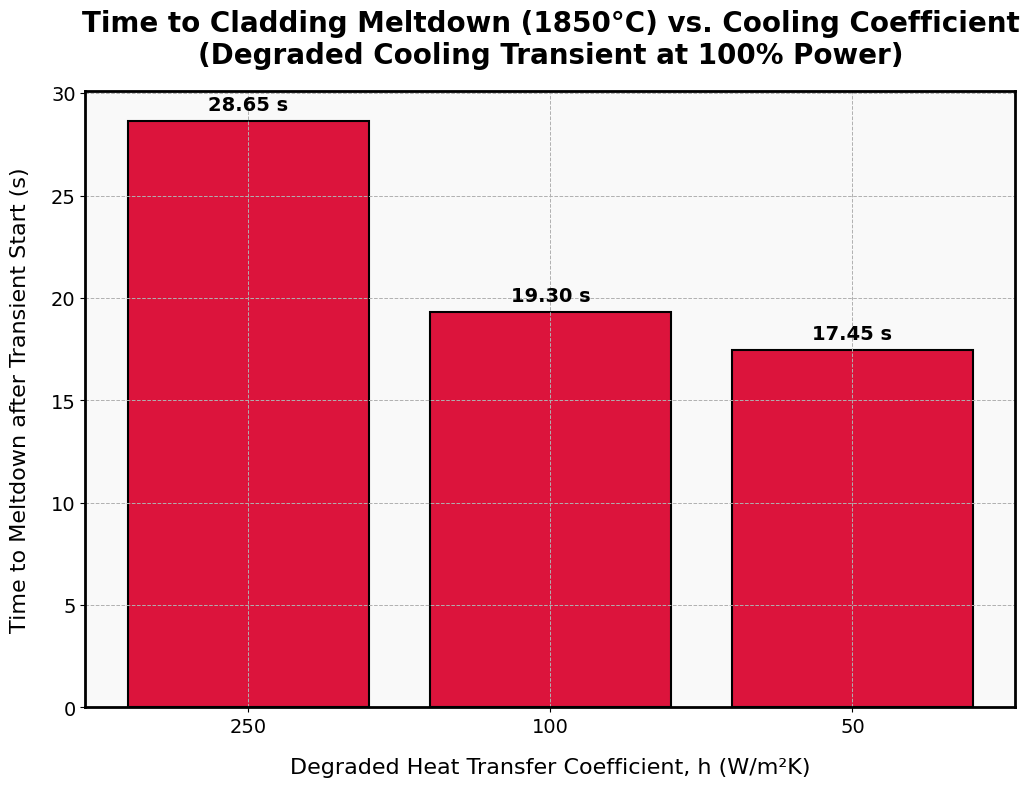

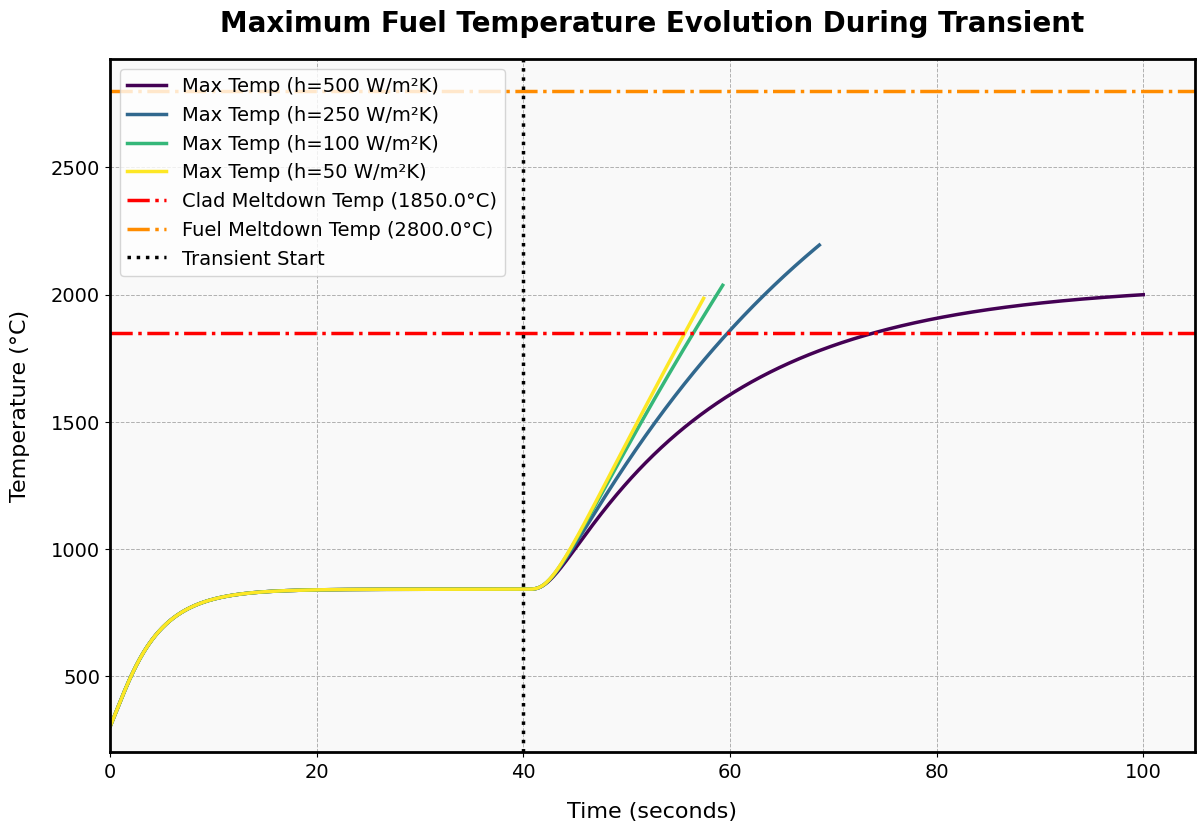

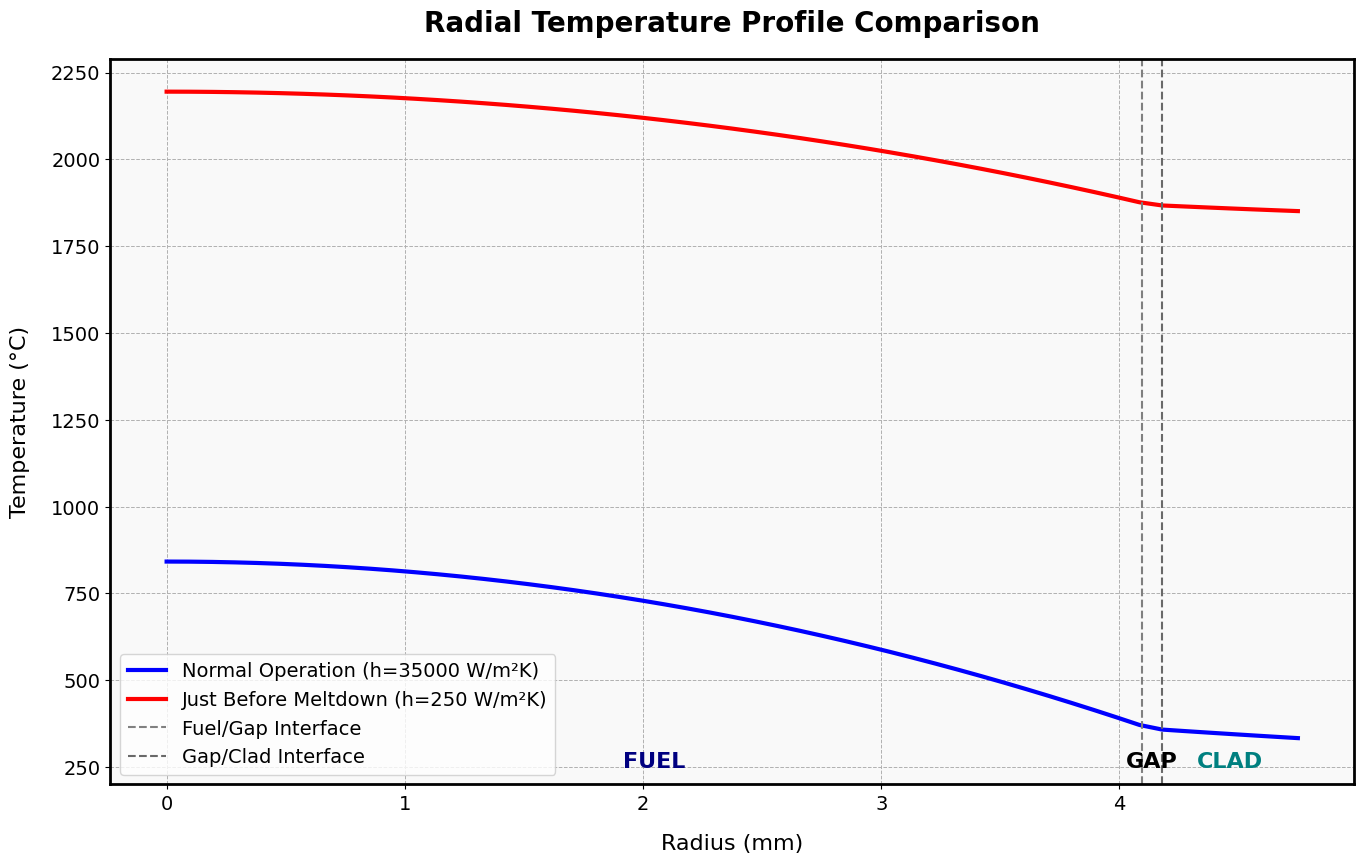

In [2]:
# This block address question B.4: changing h to see how long it takes to reach meltdown

import numpy as np
import matplotlib.pyplot as plt
import time

# =============================================================================
# 1. Physical, Numerical, and Time Parameters
# =============================================================================
print('--- Running: Fuel Rod Degraded Cooling Transient Simulation ---')

# --- Material IDs ---
FUEL_ID = 1
GAP_ID = 2
CLAD_ID = 3

# --- Geometry (From Appendix H, PWR-W) ---
r_fuel = 0.004095; gap_thickness = 0.000082; clad_thickness = 0.000572
r_gap = r_fuel + gap_thickness
r_clad = r_gap + clad_thickness
L = 1.0

# --- Material Properties ---
k_fuel = 3.0; rho_fuel = 10500; cp_fuel = 320
k_gap = 0.15; rho_gap = 0.166; cp_gap = 5193
k_clad = 15.0; rho_clad = 6550; cp_clad = 330

# --- Failure Criteria & Reference Temperatures ---
T_melt_clad = 1850.0   # °C, Melting point of Zircaloy cladding
T_melt_fuel = 2800.0   # °C, Melting point of UO2 fuel

# --- Operating Conditions ---
q_gen_normal = 3.385e8 # W/m^3, Volumetric heat generation at FULL POWER
h_normal = 35000       # W/m^2-K, Convective coefficient for normal operation
T_inf = 316.0          # Celsius, Ambient fluid temperature
T_initial = 300.0      # Celsius, Initial temperature for the "cold start" run

# --- Transient Scenarios to Test ---
h_values_to_test = [500, 250, 100, 50]
h_profile_case = 250 # The 'h' case we will use for the radial profile plot

# --- Numerical Grid ---
N = 51
r_nodes = np.linspace(0, r_clad, N)
dr = r_nodes[1] - r_nodes[0]

# --- Time Parameters ---
t_steady_state_end = 40.0
t_event_start = t_steady_state_end
total_time_limit = 100.0
dt = 0.05

# =============================================================================
# 2. Initialization
# =============================================================================
print('Initializing grids and material properties...')
r_faces = r_nodes[:-1] + dr / 2.0
r_faces = np.append(r_faces, r_clad)
cell_volumes = np.zeros(N)
cell_volumes[0] = np.pi * r_faces[0]**2 * L
for i in range(1, N):
    cell_volumes[i] = np.pi * (r_faces[i]**2 - r_faces[i-1]**2) * L
face_areas = 2 * np.pi * r_faces * L

material_ID_array = np.zeros(N, dtype=int)
material_ID_array[np.where(r_nodes <= r_fuel)] = FUEL_ID
material_ID_array[np.where((r_nodes > r_fuel) & (r_nodes <= r_gap))] = GAP_ID
material_ID_array[np.where(r_nodes > r_gap)] = CLAD_ID

k_vals = [0, k_fuel, k_gap, k_clad]
rho_vals = [0, rho_fuel, rho_gap, rho_clad]
cp_vals = [0, cp_fuel, cp_gap, cp_clad]
idx_clad_surf = N - 1

# --- Data Storage for Plots ---
results = {} # Stores {h_value: time_to_meltdown}
history_data = {} # Stores temperature histories for the T vs Time plot
T_profile_steady_state = None
T_profile_meltdown = None

# =============================================================================
# 3. Running the Transient Scenarios
# =============================================================================
print("\n--- Starting Transient Simulation Scenarios ---")

for h_transient_test in h_values_to_test:
    print(f"\n--- Testing Scenario: h = {h_transient_test} W/m^2-K ---")

    T_vector = np.full(N, T_initial)
    clad_melt_time = -1

    time_points, max_temps = [], []

    num_steps = round(total_time_limit / dt)

    for step in range(num_steps):
        current_time = (step + 1) * dt

        if current_time <= t_event_start:
            h, q_gen_fuel_current = h_normal, q_gen_normal
            if abs(current_time - t_event_start) < dt/2 and T_profile_steady_state is None:
                T_profile_steady_state = np.copy(T_vector)
        else:
            h, q_gen_fuel_current = h_transient_test, q_gen_normal

        q_gen_vals = [0, q_gen_fuel_current, 0, 0]

        A_matrix, b_vector = np.zeros((N, N)), np.zeros(N)
        for i in range(N):
            mat_id_p = material_ID_array[i]
            rho_p, cp_p, q_gen_p, k_p = rho_vals[mat_id_p], cp_vals[mat_id_p], q_gen_vals[mat_id_p], k_vals[mat_id_p]
            transient_coeff = (rho_p * cp_p * cell_volumes[i]) / dt
            b_i = transient_coeff * T_vector[i] + q_gen_p * cell_volumes[i]
            a_P_diag = transient_coeff
            if i > 0:
                k_W = k_vals[material_ID_array[i-1]]
                a_W = (2 * k_p * k_W / (k_p + k_W)) * face_areas[i-1] / dr
                A_matrix[i, i-1] = -a_W
                a_P_diag += a_W
            if i < N - 1:
                k_E = k_vals[material_ID_array[i+1]]
                a_E = (2 * k_p * k_E / (k_p + k_E)) * face_areas[i] / dr
                A_matrix[i, i+1] = -a_E
                a_P_diag += a_E
            if i == N - 1:
                conv_coeff = h * face_areas[N-1]
                a_P_diag += conv_coeff
                b_i += conv_coeff * T_inf
            A_matrix[i, i] = a_P_diag
            b_vector[i] = b_i
        T_new = np.linalg.solve(A_matrix, b_vector)

        time_points.append(current_time)
        max_temps.append(T_new[0]) # Maximum temperature is always at the center (node 0)

        if T_new[idx_clad_surf] >= T_melt_clad and current_time > t_event_start:
            time_to_meltdown = current_time - t_event_start
            print(f"!!! CLADDING MELTDOWN DETECTED at t = {current_time:.2f} s !!!")
            print(f"    Time to meltdown after event start: {time_to_meltdown:.2f} seconds.")
            results[h_transient_test] = time_to_meltdown
            if h_transient_test == h_profile_case:
                T_profile_meltdown = np.copy(T_new)
            break

        T_vector = T_new

    if clad_melt_time < 0 and step == num_steps - 1:
        print(f"    Meltdown not reached within the {total_time_limit - t_event_start} second simulation window.")
        results[h_transient_test] = float('inf')

    history_data[h_transient_test] = {'time': time_points, 'max_T': max_temps}

# =============================================================================
# 4. Visualization of Results
# =============================================================================
print('\n\n--- Final Results Summary ---')
for h_val, t_melt in results.items():
    if t_melt == float('inf'):
        print(f"h = {h_val:4} W/m^2-K  |  Time to Meltdown: > {total_time_limit - t_event_start} s")
    else:
        print(f"h = {h_val:4} W/m^2-K  |  Time to Meltdown: {t_melt:.2f} s")

# --- Plotting helper function for styling ---
def setup_plot_styling(ax, title):
    ax.set_title(title, fontsize=20, weight='bold', pad=20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)
    ax.grid(True, which='both', linestyle='--', linewidth=0.7)
    ax.set_facecolor('#f9f9f9')

# --- FIGURE 1: Bar Chart of Time to Meltdown ---
fig1, ax1 = plt.subplots(figsize=(12, 8))
h_labels = [str(h) for h in results.keys()]
melt_times = list(results.values())
bars = ax1.bar(h_labels, melt_times, color='crimson', edgecolor='black', linewidth=1.5)
setup_plot_styling(ax1, 'Time to Cladding Meltdown (1850°C) vs. Cooling Coefficient\n(Degraded Cooling Transient at 100% Power)')
ax1.set_xlabel('Degraded Heat Transfer Coefficient, h (W/m²K)', fontsize=16, labelpad=15)
ax1.set_ylabel('Time to Meltdown after Transient Start (s)', fontsize=16, labelpad=15)
ax1.bar_label(bars, fmt='%.2f s', padding=5, fontsize=14, weight='bold')

# --- FIGURE 2: Maximum Temperature vs. Time ---
fig2, ax2 = plt.subplots(figsize=(14, 9))
colors = plt.cm.viridis(np.linspace(0, 1, len(h_values_to_test)))
for i, h_val in enumerate(h_values_to_test):
    data = history_data[h_val]
    ax2.plot(data['time'], data['max_T'], color=colors[i], linestyle='-', linewidth=2.5,
             label=f'Max Temp (h={h_val} W/m²K)')

ax2.axhline(y=T_melt_clad, color='red', linestyle='-.', linewidth=2.5, label=f'Clad Meltdown Temp ({T_melt_clad}°C)')
ax2.axhline(y=T_melt_fuel, color='darkorange', linestyle='-.', linewidth=2.5, label=f'Fuel Meltdown Temp ({T_melt_fuel}°C)')
ax2.axvline(x=t_event_start, color='black', linestyle=':', linewidth=2.5, label='Transient Start')

setup_plot_styling(ax2, 'Maximum Fuel Temperature Evolution During Transient')
ax2.set_xlabel('Time (seconds)', fontsize=16, labelpad=15)
ax2.set_ylabel('Temperature (°C)', fontsize=16, labelpad=15)
ax2.legend(fontsize=14, loc='upper left')
ax2.set_ylim(bottom=200)
ax2.set_xlim(left=0)

# --- FIGURE 3: Radial Temperature Profile ---
fig3, ax3 = plt.subplots(figsize=(14, 9))
if T_profile_steady_state is not None:
    ax3.plot(r_nodes * 1000, T_profile_steady_state, 'b-', linewidth=3,
             label=f'Normal Operation (h={h_normal} W/m²K)')
if T_profile_meltdown is not None:
    ax3.plot(r_nodes * 1000, T_profile_meltdown, 'r-', linewidth=3,
             label=f'Just Before Meltdown (h={h_profile_case} W/m²K)')

ax3.axvline(x=r_fuel * 1000, color='grey', linestyle='--', label='Fuel/Gap Interface')
ax3.axvline(x=r_gap * 1000, color='dimgrey', linestyle='--', label='Gap/Clad Interface')

ax3.text(r_fuel*1000/2, 250, 'FUEL', ha='center', fontsize=16, weight='bold', color='navy')
ax3.text((r_fuel+r_gap)*1000/2, 250, 'GAP', ha='center', fontsize=16, weight='bold', color='black')
ax3.text((r_gap+r_clad)*1000/2, 250, 'CLAD', ha='center', fontsize=16, weight='bold', color='teal')

setup_plot_styling(ax3, 'Radial Temperature Profile Comparison')
ax3.set_xlabel('Radius (mm)', fontsize=16, labelpad=15)
ax3.set_ylabel('Temperature (°C)', fontsize=16, labelpad=15)
ax3.legend(fontsize=14, loc='best')
ax3.set_ylim(bottom=200)

plt.tight_layout(pad=2.0)
plt.show()